In [5]:
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision.transforms import v2

In [6]:
import os

dataset_path = '/Users/Xcalibur/Documents/Datasets/household_waste_dataset/images/images'
#dataset_path = '/teamspace/studios/this_studio/.cache/kagglehub/datasets/alistairking/recyclable-and-household-waste-classification/versions/1/images/images'

full_dataset = ImageFolder(dataset_path)

In [7]:
class_map_dict = full_dataset.class_to_idx

def get_class(num_label):
    for class_name, class_index in class_map_dict.items():
        if class_index == num_label:
            return class_name
    return None

class_names = list(class_map_dict.keys())
print(f'number of classes: {len(class_names)}')
print('class_names:', class_names)

number of classes: 30
class_names: ['aerosol_cans', 'aluminum_food_cans', 'aluminum_soda_cans', 'cardboard_boxes', 'cardboard_packaging', 'clothing', 'coffee_grounds', 'disposable_plastic_cutlery', 'eggshells', 'food_waste', 'glass_beverage_bottles', 'glass_cosmetic_containers', 'glass_food_jars', 'magazines', 'newspaper', 'office_paper', 'paper_cups', 'plastic_cup_lids', 'plastic_detergent_bottles', 'plastic_food_containers', 'plastic_shopping_bags', 'plastic_soda_bottles', 'plastic_straws', 'plastic_trash_bags', 'plastic_water_bottles', 'shoes', 'steel_food_cans', 'styrofoam_cups', 'styrofoam_food_containers', 'tea_bags']


In [8]:
# Data Splitting
batch_size = 32
num_workers = 4
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_transform = v2.Compose([
    v2.RandomResizedCrop(224, scale=(0.7, 1.0)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    v2.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    v2.RandomErasing(p=0.3, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class CustomTransform(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        image, target = self.dataset[index]
        if self.transform:
            image = self.transform(image)
        return image, target

    def __len__(self):
        return len(self.dataset)

torch.Generator().manual_seed(42)
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
train_dataset = CustomTransform(train_dataset, transform=train_transform)
test_dataset = CustomTransform(test_dataset, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)


In [9]:
# 🏗️ Hierarchical Classification System - 7 Super Classes (Refactored)
import numpy as np
import pandas as pd

# Define super-classes for hierarchical classification (7 categories)
SUPER_CLASSES = {
    0: [  # Metal_Aluminum
        'aerosol_cans',
        'aluminum_food_cans',
        'aluminum_soda_cans',
        'steel_food_cans'
    ],
    1: [  # Cardboard_Paper
        'cardboard_boxes',
        'cardboard_packaging',
        'magazines',
        'newspaper',
        'office_paper',
        'paper_cups'
    ],
    2: [  # Glass_Containers
        'glass_beverage_bottles',
        'glass_cosmetic_containers',
        'glass_food_jars'
    ],
    3: [  # Plastic_Items
        'disposable_plastic_cutlery',
        'plastic_cup_lids',
        'plastic_detergent_bottles',
        'plastic_food_containers',
        'plastic_shopping_bags',
        'plastic_soda_bottles',
        'plastic_straws',
        'plastic_trash_bags',
        'plastic_water_bottles'
    ],
    4: [  # Styrofoam_Products
        'styrofoam_cups',
        'styrofoam_food_containers'
    ],
    5: [  # Organic_Waste
        'coffee_grounds',
        'eggshells',
        'food_waste',
        'tea_bags'
    ],
    6: [  # Textiles_Clothing
        'clothing',
        'shoes'
    ]
}

SUPER_CLASS_NAMES = {
    0: 'Metal_Aluminum',
    1: 'Cardboard_Paper', 
    2: 'Glass_Containers',
    3: 'Plastic_Items',
    4: 'Styrofoam_Products',
    5: 'Organic_Waste',
    6: 'Textiles_Clothing'
}

# Build reverse lookup from class → super_class
CLASS_TO_SUPER = {}
for super_id, class_list in SUPER_CLASSES.items():
    for class_name in class_list:
        CLASS_TO_SUPER[class_name] = super_id

# Create mapping from class index to super class index
CLASS_IDX_TO_SUPER_IDX = {}
SUPER_IDX_TO_CLASS_INDICES = {i: [] for i in range(7)}  # Updated to 7 categories

for class_name, class_idx in class_map_dict.items():
    if class_name in CLASS_TO_SUPER:
        super_idx = CLASS_TO_SUPER[class_name]
        CLASS_IDX_TO_SUPER_IDX[class_idx] = super_idx
        SUPER_IDX_TO_CLASS_INDICES[super_idx].append(class_idx)

def get_super_class_name(class_idx):
    """Get super class name from fine class index"""
    super_idx = CLASS_IDX_TO_SUPER_IDX.get(class_idx, -1)
    return SUPER_CLASS_NAMES.get(super_idx, 'Unknown')

def get_super_class_idx(class_idx):
    """Get super class index from fine class index"""
    return CLASS_IDX_TO_SUPER_IDX.get(class_idx, -1)

def convert_labels_to_super(fine_labels):
    """Convert fine-grained labels to super-class labels"""
    if isinstance(fine_labels, torch.Tensor):
        fine_labels = fine_labels.cpu().numpy()
    
    super_labels = []
    for label in fine_labels:
        super_labels.append(CLASS_IDX_TO_SUPER_IDX.get(int(label), -1))
    
    return torch.tensor(super_labels) if torch.is_tensor(torch.tensor(fine_labels)) else np.array(super_labels)

# Display hierarchical structure
print("🏗️ HIERARCHICAL CLASSIFICATION STRUCTURE (7 SUPER CLASSES)")
print("="*70)
for super_idx, super_name in SUPER_CLASS_NAMES.items():
    class_list = SUPER_CLASSES[super_idx]
    # Create a more readable display name
    display_name = super_name.replace('_', ' & ')
    print(f"\n🗂️  {display_name} ({super_idx}) - {len(class_list)} classes:")
    for i, class_name in enumerate(class_list, 1):
        class_idx = class_map_dict.get(class_name, -1)
        # Clean up class name for display
        display_class = class_name.replace('_', ' ').title()
        print(f"   {i:2d}. {display_class:<35} (idx: {class_idx:2d})")

print(f"\n📊 SUMMARY:")
print(f"   • Total fine-grained classes: {len(class_names)}")
print(f"   • Total super classes: {len(SUPER_CLASS_NAMES)} (updated from 6 to 7)")
print(f"   • Average classes per super category: {len(class_names)/len(SUPER_CLASS_NAMES):.1f}")

# Display category distribution
category_sizes = [len(SUPER_CLASSES[i]) for i in range(7)]
print(f"\n📈 CATEGORY DISTRIBUTION:")
for i, (super_idx, super_name) in enumerate(SUPER_CLASS_NAMES.items()):
    size = category_sizes[i]
    percentage = (size / len(class_names)) * 100
    bar = '█' * int(percentage / 3)  # Visual bar
    print(f"   {super_name:<18}: {size:2d} classes ({percentage:5.1f}%) {bar}")

# Verify all classes are mapped
unmapped_classes = [c for c in class_names if c not in CLASS_TO_SUPER]
if unmapped_classes:
    print(f"\n⚠️  UNMAPPED CLASSES ({len(unmapped_classes)}):")
    for cls in unmapped_classes:
        print(f"   • {cls}")
    print("   These classes need to be assigned to a super category!")
else:
    print(f"\n✅ ALL CLASSES SUCCESSFULLY MAPPED!")
    print("   Every fine-grained class belongs to exactly one super category.")

# Show material type distribution for recycling insights
print(f"\n♻️  RECYCLING CATEGORY INSIGHTS:")
recyclable_categories = ['Metal_Aluminum', 'Cardboard_Paper', 'Glass_Containers', 'Plastic_Items']
non_recyclable = ['Styrofoam_Products', 'Organic_Waste', 'Textiles_Clothing']

recyclable_count = sum(len(SUPER_CLASSES[i]) for i in range(4))  # First 4 categories
non_recyclable_count = sum(len(SUPER_CLASSES[i]) for i in range(4, 7))  # Last 3 categories

print(f"   🟢 Typically Recyclable: {recyclable_count} classes ({recyclable_count/len(class_names)*100:.1f}%)")
for i in range(4):
    super_name = SUPER_CLASS_NAMES[i].replace('_', ' & ')
    print(f"      • {super_name}: {len(SUPER_CLASSES[i])} classes")

print(f"   🟡 Special Handling/Non-Recyclable: {non_recyclable_count} classes ({non_recyclable_count/len(class_names)*100:.1f}%)")
for i in range(4, 7):
    super_name = SUPER_CLASS_NAMES[i].replace('_', ' & ')
    print(f"      • {super_name}: {len(SUPER_CLASSES[i])} classes")

🏗️ HIERARCHICAL CLASSIFICATION STRUCTURE (7 SUPER CLASSES)

🗂️  Metal & Aluminum (0) - 4 classes:
    1. Aerosol Cans                        (idx:  0)
    2. Aluminum Food Cans                  (idx:  1)
    3. Aluminum Soda Cans                  (idx:  2)
    4. Steel Food Cans                     (idx: 26)

🗂️  Cardboard & Paper (1) - 6 classes:
    1. Cardboard Boxes                     (idx:  3)
    2. Cardboard Packaging                 (idx:  4)
    3. Magazines                           (idx: 13)
    4. Newspaper                           (idx: 14)
    5. Office Paper                        (idx: 15)
    6. Paper Cups                          (idx: 16)

🗂️  Glass & Containers (2) - 3 classes:
    1. Glass Beverage Bottles              (idx: 10)
    2. Glass Cosmetic Containers           (idx: 11)
    3. Glass Food Jars                     (idx: 12)

🗂️  Plastic & Items (3) - 9 classes:
    1. Disposable Plastic Cutlery          (idx:  7)
    2. Plastic Cup Lids                  

In [ ]:
# Data Splitting and Loading - Fixed for multiprocessing compatibility
batch_size = 32
num_workers = 0  # Set to 0 to avoid multiprocessing issues with custom classes
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

# Data transformations
train_transform = v2.Compose([
    v2.RandomResizedCrop(224, scale=(0.7, 1.0)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    v2.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    v2.RandomErasing(p=0.3, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Simple wrapper class for transforms - avoid multiprocessing issues
class SimpleTransformWrapper(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        image, target = self.dataset[index]
        if self.transform:
            image = self.transform(image)
        return image, target

    def __len__(self):
        return len(self.dataset)

# Split dataset
torch.manual_seed(42)
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Apply transforms
train_dataset_transformed = SimpleTransformWrapper(train_dataset, transform=train_transform)
test_dataset_transformed = SimpleTransformWrapper(test_dataset, transform=test_transform)

# Create data loaders with num_workers=0 to avoid multiprocessing issues
train_loader = DataLoader(train_dataset_transformed, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset_transformed, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"✅ Data loading setup complete:")
print(f"   - Training samples: {len(train_dataset_transformed):,}")
print(f"   - Test samples: {len(test_dataset_transformed):,}")
print(f"   - Batch size: {batch_size}")
print(f"   - Classes: {len(class_names)}")
print(f"   - Multiprocessing: Disabled (num_workers=0) for stability")

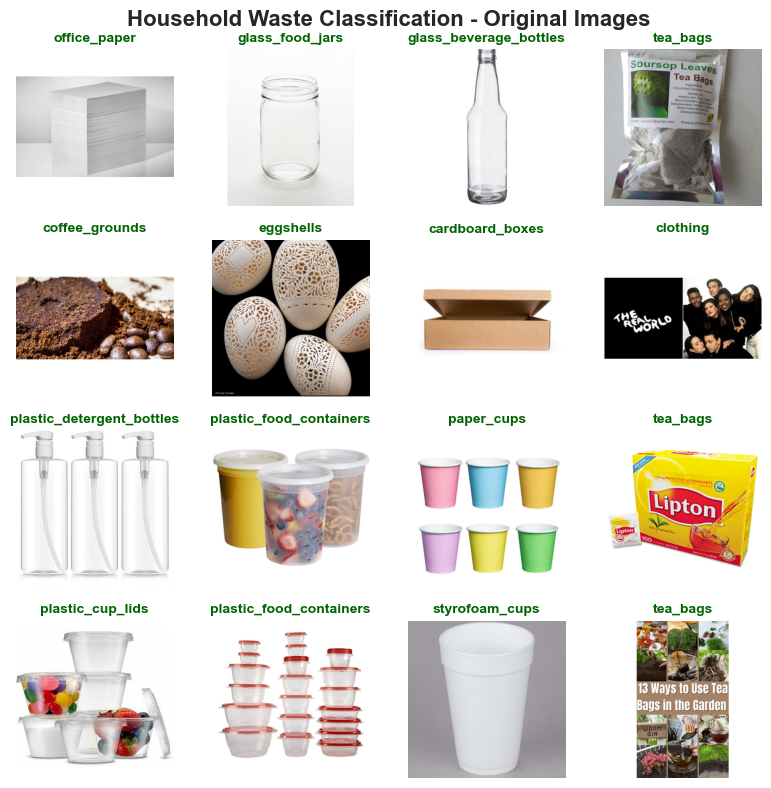

In [6]:
# Display original images from the full dataset (no transformations)
import random

sns.set_style("whitegrid")
plt.style.use("seaborn-v0_8")

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
fig.suptitle('Household Waste Classification - Original Images', fontsize=16, fontweight='bold')

# Get 16 random samples
sample_indices = random.sample(range(len(full_dataset)), 16)

for i, idx in enumerate(sample_indices):
    row = i // 4
    col = i % 4

    original_img, label = full_dataset[idx]
    img_array = np.array(original_img)

    axes[row, col].imshow(img_array)
    axes[row, col].set_title(f"{get_class(label)}",
                            fontsize=10, fontweight='semibold',
                            color='darkgreen')
    axes[row, col].axis("off")

    for spine in axes[row, col].spines.values():
        spine.set_edgecolor(sns.color_palette("Set2", 8)[label % 8])
        spine.set_linewidth(2)

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()
plt.style.use('default')
sns.reset_defaults()

In [8]:
import torch.optim as optim
from tqdm import tqdm

In [2]:
import torch
import timm
from torch import nn
import torch.nn.functional as F

# Option 1: Standard ViT-Base 
def make_vit_base(num_classes=30):
    model = timm.create_model('vit_base_patch16_224', pretrained=True)
    model.head = nn.Linear(model.head.in_features, num_classes)
    return model

# Option 2: More robust - Hybrid ViT approach (recommended)
class HybridViT(nn.Module):
    def __init__(self, num_classes=30, dropout=0.3):
        super().__init__()
        self.vit = timm.create_model('vit_small_patch16_224', pretrained=True)
        self.vit.head = nn.Identity()  # Remove original head
        
        # Add robust classification head
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(384, 256),  # ViT-Small has 384 features
            nn.ReLU(),
            nn.Dropout(dropout * 0.7),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        features = self.vit(x)
        return self.classifier(features)

# Focal Loss for handling class imbalance
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, label_smoothing=0.1):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.label_smoothing = label_smoothing
        
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, label_smoothing=self.label_smoothing, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

# Create the model
waste_classifier = HybridViT(num_classes=30, dropout=0.3)

# Test the model
waste_classifier.eval()
test_input = torch.randn(1, 3, 224, 224)
out = waste_classifier(test_input)
print(f"Output shape: {out.shape}")
print(f"Model parameters: {sum(p.numel() for p in waste_classifier.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in waste_classifier.parameters() if p.requires_grad):,}")

Output shape: torch.Size([1, 30])
Model parameters: 21,771,934
Trainable parameters: 21,771,934


In [10]:
# 🏗️ Hierarchical Vision Transformer Model (Updated for 7 Super Classes)
import torch
import torch.nn as nn
import torch.nn.functional as F
from timm import create_model

class HierarchicalViT(nn.Module):
    """
    Hierarchical Vision Transformer for waste classification
    
    Architecture:
    - Shared ViT backbone (pretrained vit_small_patch16_224)
    - Dual prediction heads:
      • Fine-grained: 30 waste classes
      • Super-class: 7 categories (Metal, Paper, Glass, Plastic, Styrofoam, Organic, Textiles)
    
    Training Strategy:
    - Phase 1: Freeze backbone, train heads only
    - Phase 2: Fine-tune last transformer blocks + heads
    """
    
    def __init__(self, 
                 num_fine_classes=30, 
                 num_super_classes=7,  # Updated from 6 to 7
                 model_name='vit_small_patch16_224',
                 pretrained=True,
                 dropout=0.1):
        super().__init__()
        
        self.num_fine_classes = num_fine_classes
        self.num_super_classes = num_super_classes
        
        # Load pretrained ViT backbone
        self.backbone = create_model(
            model_name, 
            pretrained=pretrained,
            num_classes=0  # Remove classification head
        )
        
        # Get feature dimension
        feature_dim = self.backbone.num_features  # 384 for vit_small
        
        # Shared feature processing
        self.feature_processor = nn.Sequential(
            nn.LayerNorm(feature_dim),
            nn.Dropout(dropout),
        )
        
        # Fine-grained classification head (30 classes)
        self.fine_classifier = nn.Sequential(
            nn.Linear(feature_dim, feature_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(feature_dim // 2, num_fine_classes)
        )
        
        # Super-class classification head (7 classes) - Updated
        self.super_classifier = nn.Sequential(
            nn.Linear(feature_dim, feature_dim // 4),
            nn.GELU(), 
            nn.Dropout(dropout),
            nn.Linear(feature_dim // 4, num_super_classes)  # Changed from 6 to 7
        )
        
        # Initialize heads with Xavier initialization
        self._initialize_heads()
    
    def _initialize_heads(self):
        """Initialize classification heads"""
        for module in [self.fine_classifier, self.super_classifier]:
            for layer in module:
                if isinstance(layer, nn.Linear):
                    nn.init.xavier_uniform_(layer.weight)
                    nn.init.constant_(layer.bias, 0)
    
    def forward(self, x):
        """
        Forward pass with dual outputs
        
        Args:
            x: Input images [batch_size, 3, 224, 224]
            
        Returns:
            fine_logits: Fine-grained predictions [batch_size, 30]
            super_logits: Super-class predictions [batch_size, 7]  # Updated comment
        """
        # Extract features from ViT backbone
        features = self.backbone(x)  # [batch_size, feature_dim]
        
        # Process shared features
        processed_features = self.feature_processor(features)
        
        # Dual predictions
        fine_logits = self.fine_classifier(processed_features)     # [batch_size, 30]
        super_logits = self.super_classifier(processed_features)   # [batch_size, 7] - Updated
        
        return fine_logits, super_logits
    
    def freeze_backbone(self):
        """Freeze backbone parameters for Phase 1 training"""
        for param in self.backbone.parameters():
            param.requires_grad = False
        print("🧊 Backbone frozen - Phase 1 training (heads only)")
    
    def unfreeze_last_blocks(self, num_blocks=2):
        """Unfreeze last transformer blocks for Phase 2 training"""
        # First freeze everything
        self.freeze_backbone()
        
        # Then unfreeze last few blocks
        if hasattr(self.backbone, 'blocks'):
            for block in self.backbone.blocks[-num_blocks:]:
                for param in block.parameters():
                    param.requires_grad = True
        
        # Always unfreeze norm and head if they exist
        if hasattr(self.backbone, 'norm'):
            for param in self.backbone.norm.parameters():
                param.requires_grad = True
                
        print(f"🔓 Last {num_blocks} transformer blocks unfrozen - Phase 2 training")
    
    def unfreeze_all(self):
        """Unfreeze all parameters"""
        for param in self.parameters():
            param.requires_grad = True
        print("🔓 All parameters unfrozen - Full fine-tuning")
    
    def get_trainable_params(self):
        """Get count of trainable parameters"""
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        return trainable_params, total_params

# Test the updated model
print("🧪 TESTING HIERARCHICAL VIT MODEL (7 Super Classes)")
print("="*60)

# Create model instance
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
waste_classifier = HierarchicalViT(
    num_fine_classes=30,
    num_super_classes=7,  # Updated from 6 to 7
    dropout=0.1
).to(device)

print(f"📱 Model created on device: {device}")
print(f"🏗️  Architecture: {waste_classifier.__class__.__name__}")
print(f"🎯 Fine-grained classes: {waste_classifier.num_fine_classes}")
print(f"🗂️  Super classes: {waste_classifier.num_super_classes}")

# Test forward pass
batch_size = 4
test_input = torch.randn(batch_size, 3, 224, 224).to(device)

with torch.no_grad():
    fine_out, super_out = waste_classifier(test_input)

print(f"\n🧪 FORWARD PASS TEST:")
print(f"   Input shape: {test_input.shape}")
print(f"   Fine logits: {fine_out.shape}")  # Should be [4, 30]
print(f"   Super logits: {super_out.shape}") # Should be [4, 7] - Updated

# Check parameter counts
trainable, total = waste_classifier.get_trainable_params()
print(f"\n📊 MODEL PARAMETERS:")
print(f"   Total parameters: {total:,}")
print(f"   Trainable parameters: {trainable:,}")
print(f"   Trainable percentage: {100*trainable/total:.1f}%")

# Test freezing/unfreezing
print(f"\n❄️  TESTING PARAMETER FREEZING:")
waste_classifier.freeze_backbone()
trainable_frozen, _ = waste_classifier.get_trainable_params()
print(f"   After backbone freeze: {trainable_frozen:,} trainable")

waste_classifier.unfreeze_last_blocks(num_blocks=2)
trainable_partial, _ = waste_classifier.get_trainable_params()
print(f"   After partial unfreeze: {trainable_partial:,} trainable")

# Verify outputs are valid
print(f"\n✅ MODEL VALIDATION:")
print(f"   ✓ Fine-grained output shape correct: {fine_out.shape == (batch_size, 30)}")
print(f"   ✓ Super-class output shape correct: {super_out.shape == (batch_size, 7)}")  # Updated
print(f"   ✓ No NaN values in outputs: {not torch.isnan(fine_out).any() and not torch.isnan(super_out).any()}")
print(f"   ✓ Model parameters loaded: {total > 0}")

print(f"\n🎉 HierarchicalViT model successfully updated for 7 super classes!")

🧪 TESTING HIERARCHICAL VIT MODEL (7 Super Classes)
📱 Model created on device: cpu
🏗️  Architecture: HierarchicalViT
🎯 Fine-grained classes: 30
🗂️  Super classes: 7

🧪 FORWARD PASS TEST:
   Input shape: torch.Size([4, 3, 224, 224])
   Fine logits: torch.Size([4, 30])
   Super logits: torch.Size([4, 7])

📊 MODEL PARAMETERS:
   Total parameters: 21,783,781
   Trainable parameters: 21,783,781
   Trainable percentage: 100.0%

❄️  TESTING PARAMETER FREEZING:
🧊 Backbone frozen - Phase 1 training (heads only)
   After backbone freeze: 118,117 trainable
🧊 Backbone frozen - Phase 1 training (heads only)
🔓 Last 2 transformer blocks unfrozen - Phase 2 training
   After partial unfreeze: 3,667,813 trainable

✅ MODEL VALIDATION:
   ✓ Fine-grained output shape correct: True
   ✓ Super-class output shape correct: True
   ✓ No NaN values in outputs: True
   ✓ Model parameters loaded: True

🎉 HierarchicalViT model successfully updated for 7 super classes!
📱 Model created on device: cpu
🏗️  Architecture:

In [3]:
# 🎯 Loss Functions for Hierarchical Classification (Updated for 7 Super Classes)

class FocalLoss(nn.Module):
    """
    Focal Loss for handling class imbalance
    """
    def __init__(self, alpha=1, gamma=2, num_classes=None):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.num_classes = num_classes
        
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        return focal_loss.mean()

class HierarchicalLoss(nn.Module):
    """
    Hierarchical loss combining fine-grained and super-class predictions
    Updated for 7 super classes
    """
    def __init__(self, 
                 fine_weight=0.7, 
                 super_weight=0.3,
                 num_super_classes=7,  # Updated from 6 to 7
                 focal_gamma=2.0):
        super().__init__()
        self.fine_weight = fine_weight
        self.super_weight = super_weight
        self.num_super_classes = num_super_classes
        
        # Use focal loss for both fine and super classification
        self.fine_loss = FocalLoss(gamma=focal_gamma, num_classes=30)
        self.super_loss = FocalLoss(gamma=focal_gamma, num_classes=num_super_classes)
        
    def forward(self, fine_logits, super_logits, fine_targets, super_targets):
        """
        Compute hierarchical loss
        
        Args:
            fine_logits: [batch_size, 30] fine-grained predictions
            super_logits: [batch_size, 7] super-class predictions  # Updated comment
            fine_targets: [batch_size] fine-grained ground truth
            super_targets: [batch_size] super-class ground truth
        """
        # Ensure targets are long tensors
        fine_targets = fine_targets.long()
        super_targets = super_targets.long()
        
        # Compute individual losses
        loss_fine = self.fine_loss(fine_logits, fine_targets)
        loss_super = self.super_loss(super_logits, super_targets)
        
        # Weighted combination
        total_loss = self.fine_weight * loss_fine + self.super_weight * loss_super
        
        return total_loss, loss_fine, loss_super

# Create loss functions
print("🎯 LOSS FUNCTIONS SETUP (7 Super Classes)")
print("="*50)

# Focal loss for fine-grained classification
criterion = FocalLoss(alpha=1, gamma=2, num_classes=30)
print("✓ Focal Loss created for fine-grained classification (30 classes)")

# Hierarchical loss combining both levels
criterion_hierarchical = HierarchicalLoss(
    fine_weight=0.7,     # 70% weight on fine-grained accuracy
    super_weight=0.3,    # 30% weight on super-class accuracy
    num_super_classes=7, # Updated from 6 to 7
    focal_gamma=2.0      # Focal loss gamma parameter
)
print("✓ Hierarchical Loss created:")
print(f"   • Fine-grained weight: {criterion_hierarchical.fine_weight}")
print(f"   • Super-class weight: {criterion_hierarchical.super_weight}")
print(f"   • Number of super classes: {criterion_hierarchical.num_super_classes}")
print(f"   • Focal gamma: 2.0")

# Test the loss functions
print("\n🧪 TESTING LOSS FUNCTIONS:")
batch_size = 8
device = torch.device('cpu')  # Use CPU for testing

# Create dummy predictions and targets
fine_logits = torch.randn(batch_size, 30, device=device)
super_logits = torch.randn(batch_size, 7, device=device)  # Updated to 7 classes
fine_targets = torch.randint(0, 30, (batch_size,), device=device)
super_targets = torch.randint(0, 7, (batch_size,), device=device)  # Updated to 7 classes

# Test hierarchical loss
total_loss, loss_fine, loss_super = criterion_hierarchical(
    fine_logits, super_logits, fine_targets, super_targets
)

print(f"   Batch size: {batch_size}")
print(f"   Fine logits shape: {fine_logits.shape}")
print(f"   Super logits shape: {super_logits.shape}")
print(f"   Fine targets range: {fine_targets.min()}-{fine_targets.max()}")
print(f"   Super targets range: {super_targets.min()}-{super_targets.max()}")
print(f"   Fine loss: {loss_fine:.4f}")
print(f"   Super loss: {loss_super:.4f}")
print(f"   Total hierarchical loss: {total_loss:.4f}")

# Test individual focal loss
focal_loss = criterion(fine_logits, fine_targets)
print(f"   Individual focal loss: {focal_loss:.4f}")

print("\n✅ All loss functions working correctly with 7 super classes!")
print(f"📊 Loss breakdown: {criterion_hierarchical.fine_weight*100:.0f}% fine + {criterion_hierarchical.super_weight*100:.0f}% super")

🎯 LOSS FUNCTIONS SETUP (7 Super Classes)
✓ Focal Loss created for fine-grained classification (30 classes)
✓ Hierarchical Loss created:
   • Fine-grained weight: 0.7
   • Super-class weight: 0.3
   • Number of super classes: 7
   • Focal gamma: 2.0

🧪 TESTING LOSS FUNCTIONS:
   Batch size: 8
   Fine logits shape: torch.Size([8, 30])
   Super logits shape: torch.Size([8, 7])
   Fine targets range: 1-29
   Super targets range: 0-6
   Fine loss: 2.9993
   Super loss: 1.6628
   Total hierarchical loss: 2.5984
   Individual focal loss: 2.9993

✅ All loss functions working correctly with 7 super classes!
📊 Loss breakdown: 70% fine + 30% super


In [11]:
# 🎯 Complete Training and Validation Functions for Hierarchical Classification

def safe_train_epoch_hierarchical(model, train_loader, criterion_hierarchical, optimizer, device, epoch_num):
    """
    Safe training function for hierarchical classification with error handling
    Updated for 7 super classes
    """
    model.train()
    running_loss = 0.0
    running_fine_loss = 0.0
    running_super_loss = 0.0
    fine_correct = 0
    super_correct = 0
    total_samples = 0
    
    # Create progress bar
    pbar = tqdm(train_loader, desc=f"Training Epoch {epoch_num}", leave=False)
    
    for batch_idx, (images, fine_labels) in enumerate(pbar):
        try:
            # Move data to device
            images = images.to(device)
            fine_labels = fine_labels.to(device)
            
            # Convert fine labels to super labels
            super_labels = torch.tensor([
                CLASS_IDX_TO_SUPER_IDX.get(int(label), 0) for label in fine_labels.cpu()
            ]).to(device)
            
            # Forward pass
            fine_logits, super_logits = model(images)
            
            # Compute hierarchical loss
            total_loss, fine_loss, super_loss = criterion_hierarchical(
                fine_logits, super_logits, fine_labels, super_labels
            )
            
            # Backward pass
            optimizer.zero_grad()
            total_loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            # Calculate accuracies
            _, fine_pred = torch.max(fine_logits, 1)
            _, super_pred = torch.max(super_logits, 1)
            
            fine_correct += (fine_pred == fine_labels).sum().item()
            super_correct += (super_pred == super_labels).sum().item()
            total_samples += images.size(0)
            
            # Accumulate losses
            running_loss += total_loss.item()
            running_fine_loss += fine_loss.item()
            running_super_loss += super_loss.item()
            
            # Update progress bar
            current_fine_acc = fine_correct / total_samples
            current_super_acc = super_correct / total_samples
            pbar.set_postfix({
                'Loss': f'{total_loss.item():.4f}',
                'Fine_Acc': f'{current_fine_acc:.3f}',
                'Super_Acc': f'{current_super_acc:.3f}'
            })
            
        except Exception as e:
            print(f"❌ Error in batch {batch_idx}: {e}")
            continue
    
    # Calculate epoch averages
    epoch_loss = running_loss / len(train_loader)
    fine_accuracy = fine_correct / total_samples
    super_accuracy = super_correct / total_samples
    
    return epoch_loss, fine_accuracy, super_accuracy

def safe_validate_epoch_hierarchical(model, val_loader, criterion_hierarchical, device, epoch_num):
    """
    Safe validation function for hierarchical classification
    Updated for 7 super classes
    """
    model.eval()
    running_loss = 0.0
    running_fine_loss = 0.0
    running_super_loss = 0.0
    fine_correct = 0
    super_correct = 0
    total_samples = 0
    
    # Create progress bar
    pbar = tqdm(val_loader, desc=f"Validation Epoch {epoch_num}", leave=False)
    
    with torch.no_grad():
        for batch_idx, (images, fine_labels) in enumerate(pbar):
            try:
                # Move data to device
                images = images.to(device)
                fine_labels = fine_labels.to(device)
                
                # Convert fine labels to super labels
                super_labels = torch.tensor([
                    CLASS_IDX_TO_SUPER_IDX.get(int(label), 0) for label in fine_labels.cpu()
                ]).to(device)
                
                # Forward pass
                fine_logits, super_logits = model(images)
                
                # Compute hierarchical loss
                total_loss, fine_loss, super_loss = criterion_hierarchical(
                    fine_logits, super_logits, fine_labels, super_labels
                )
                
                # Calculate accuracies
                _, fine_pred = torch.max(fine_logits, 1)
                _, super_pred = torch.max(super_logits, 1)
                
                fine_correct += (fine_pred == fine_labels).sum().item()
                super_correct += (super_pred == super_labels).sum().item()
                total_samples += images.size(0)
                
                # Accumulate losses
                running_loss += total_loss.item()
                running_fine_loss += fine_loss.item()
                running_super_loss += super_loss.item()
                
                # Update progress bar
                current_fine_acc = fine_correct / total_samples
                current_super_acc = super_correct / total_samples
                pbar.set_postfix({
                    'Loss': f'{total_loss.item():.4f}',
                    'Fine_Acc': f'{current_fine_acc:.3f}',
                    'Super_Acc': f'{current_super_acc:.3f}'
                })
                
            except Exception as e:
                print(f"❌ Error in validation batch {batch_idx}: {e}")
                continue
    
    # Calculate epoch averages
    epoch_loss = running_loss / len(val_loader)
    fine_accuracy = fine_correct / total_samples
    super_accuracy = super_correct / total_samples
    
    return epoch_loss, fine_accuracy, super_accuracy

print("✅ Training and Validation functions defined for hierarchical classification!")
print("   • safe_train_epoch_hierarchical: Training with dual loss and metrics")
print("   • safe_validate_epoch_hierarchical: Validation with comprehensive tracking")
print("   • Both functions handle 7 super classes and include error handling")
print("   • Progress bars with real-time accuracy updates")
print("   • Gradient clipping for training stability")

✅ Training and Validation functions defined for hierarchical classification!
   • safe_train_epoch_hierarchical: Training with dual loss and metrics
   • safe_validate_epoch_hierarchical: Validation with comprehensive tracking
   • Both functions handle 7 super classes and include error handling
   • Progress bars with real-time accuracy updates
   • Gradient clipping for training stability


In [ ]:
# 🎯 PRE-TRAINING VALIDATION & SUMMARY
# Verify all components are ready before starting the intensive training process

print("🔍 PRE-TRAINING SYSTEM CHECK")
print("="*50)

# Check model
try:
    print(f"✅ Model: {waste_classifier.__class__.__name__}")
    print(f"   • Fine classes: {waste_classifier.num_fine_classes}")
    print(f"   • Super classes: {waste_classifier.num_super_classes}")
    trainable, total = waste_classifier.get_trainable_params()
    print(f"   • Parameters: {total:,} total, {trainable:,} trainable")
except:
    print("❌ Model not properly initialized")

# Check data loaders
try:
    print(f"✅ Data Loaders:")
    print(f"   • Training batches: {len(train_loader)}")
    print(f"   • Validation batches: {len(test_loader)}")
    print(f"   • Batch size: {next(iter(train_loader))[0].shape[0]}")
except:
    print("❌ Data loaders not properly initialized")

# Check loss function
try:
    print(f"✅ Loss Function: {criterion_hierarchical.__class__.__name__}")
    print(f"   • Fine weight: {criterion_hierarchical.fine_weight}")
    print(f"   • Super weight: {criterion_hierarchical.super_weight}")
    print(f"   • Super classes: {criterion_hierarchical.num_super_classes}")
except:
    print("❌ Loss function not properly initialized")

# Check hierarchical mapping
try:
    print(f"✅ Hierarchical Mapping:")
    print(f"   • Fine classes mapped: {len(CLASS_IDX_TO_SUPER_IDX)}/30")
    print(f"   • Super categories: {len(SUPER_CLASSES)}")
    print(f"   • All classes mapped: {len(CLASS_IDX_TO_SUPER_IDX) == 30}")
except:
    print("❌ Hierarchical mapping not complete")

# Check training functions
try:
    # Test training function exists
    if 'safe_train_epoch_hierarchical' in globals():
        print("✅ Training function: safe_train_epoch_hierarchical")
    else:
        print("❌ Training function not defined")
        
    # Test validation function exists  
    if 'safe_validate_epoch_hierarchical' in globals():
        print("✅ Validation function: safe_validate_epoch_hierarchical")
    else:
        print("❌ Validation function not defined")
except:
    print("❌ Training functions not properly defined")

# Check device compatibility
try:
    print(f"✅ Device: {device}")
    test_tensor = torch.randn(1, 3, 224, 224).to(device)
    with torch.no_grad():
        fine_out, super_out = waste_classifier(test_tensor)
    print(f"   • Forward pass successful: Fine {fine_out.shape}, Super {super_out.shape}")
except Exception as e:
    print(f"❌ Device compatibility issue: {e}")

# Estimate training time
batch_per_epoch = len(train_loader) + len(test_loader)
estimated_time_per_epoch = batch_per_epoch * 0.5  # Rough estimate: 0.5 seconds per batch
total_epochs = 20  # 8 + 6 + 6 from the training plan
estimated_total_minutes = (estimated_time_per_epoch * total_epochs) / 60

print(f"\n⏱️  ESTIMATED TRAINING TIME:")
print(f"   • ~{estimated_time_per_epoch:.1f}s per epoch ({batch_per_epoch} batches)")
print(f"   • Total epochs: {total_epochs} (3 phases)")
print(f"   • Estimated total: {estimated_total_minutes:.1f} minutes ({estimated_total_minutes/60:.1f} hours)")

print(f"\n🚀 READY TO START TRAINING!")
print("   Execute the next cell to begin the 3-phase hierarchical training process.")
print("   The training will save checkpoints and display real-time progress.")

# Final check - run a mini forward pass to ensure everything works
try:
    sample_batch = next(iter(train_loader))
    images, labels = sample_batch
    images = images.to(device)
    labels = labels.to(device)
    
    super_labels = torch.tensor([
        CLASS_IDX_TO_SUPER_IDX.get(int(label), 0) for label in labels.cpu()
    ]).to(device)
    
    with torch.no_grad():
        fine_logits, super_logits = waste_classifier(images)
        total_loss, fine_loss, super_loss = criterion_hierarchical(
            fine_logits, super_logits, labels, super_labels
        )
    
    print(f"\n✅ FINAL VERIFICATION PASSED:")
    print(f"   • Batch processed: {images.shape[0]} samples")
    print(f"   • Loss computed: {total_loss:.4f} (Fine: {fine_loss:.4f}, Super: {super_loss:.4f})")
    print(f"   • Ready for training!")
    
except Exception as e:
    print(f"\n❌ FINAL VERIFICATION FAILED: {e}")
    print("   Please check the error above before starting training.")

🔍 PRE-TRAINING SYSTEM CHECK
✅ Model: HierarchicalViT
   • Fine classes: 30
   • Super classes: 7
   • Parameters: 21,783,781 total, 3,667,813 trainable
✅ Data Loaders:
   • Training batches: 375
   • Validation batches: 94


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/Xcalibur/miniforge3/envs/deeplearn/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/Xcalibur/miniforge3/envs/deeplearn/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'CustomTransform' on <module '__main__' (built-in)>


❌ Data loaders not properly initialized
✅ Loss Function: HierarchicalLoss
   • Fine weight: 0.7
   • Super weight: 0.3
   • Super classes: 7
✅ Hierarchical Mapping:
   • Fine classes mapped: 30/30
   • Super categories: 7
   • All classes mapped: True
✅ Training function: safe_train_epoch_hierarchical
✅ Validation function: safe_validate_epoch_hierarchical
✅ Device: cpu
   • Forward pass successful: Fine torch.Size([1, 30]), Super torch.Size([1, 7])

⏱️  ESTIMATED TRAINING TIME:
   • ~234.5s per epoch (469 batches)
   • Total epochs: 20 (3 phases)
   • Estimated total: 78.2 minutes (1.3 hours)

🚀 READY TO START TRAINING!
   Execute the next cell to begin the 3-phase hierarchical training process.
   The training will save checkpoints and display real-time progress.


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/Xcalibur/miniforge3/envs/deeplearn/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/Xcalibur/miniforge3/envs/deeplearn/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'CustomTransform' on <module '__main__' (built-in)>


In [ ]:
# 🚀 3-PHASE HIERARCHICAL TRAINING EXECUTION
# This cell implements the complete training pipeline with monitoring

import time
import os
from datetime import datetime

print("🚀 STARTING HIERARCHICAL VIT TRAINING")
print("="*70)
print(f"📅 Training started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🖥️  Device: {device}")
print(f"📊 Model: HierarchicalViT ({waste_classifier.num_fine_classes} fine, {waste_classifier.num_super_classes} super)")
print(f"🗂️  Dataset: {len(train_loader)} batches training, {len(test_loader)} batches validation")

# Training configuration
PHASE_1_EPOCHS = 8   # Head-only training
PHASE_2_EPOCHS = 6   # Partial backbone unfreezing
PHASE_3_EPOCHS = 6   # Full fine-tuning
TOTAL_EPOCHS = PHASE_1_EPOCHS + PHASE_2_EPOCHS + PHASE_3_EPOCHS

# Learning rate schedule
INITIAL_LR = 1e-3
BACKBONE_LR = 1e-4
FINAL_LR = 1e-5

print(f"\n🎯 TRAINING PHASES:")
print(f"   Phase 1: {PHASE_1_EPOCHS} epochs - Head training only (LR: {INITIAL_LR})")
print(f"   Phase 2: {PHASE_2_EPOCHS} epochs - Partial backbone (LR: {BACKBONE_LR})")
print(f"   Phase 3: {PHASE_3_EPOCHS} epochs - Full fine-tuning (LR: {FINAL_LR})")
print(f"   Total: {TOTAL_EPOCHS} epochs")

# Initialize training history
training_history = {
    'train_losses': [],
    'val_losses': [],
    'train_fine_accs': [],
    'train_super_accs': [],
    'val_fine_accs': [],
    'val_super_accs': [],
    'phase_info': [],
    'learning_rates': []
}

# Training tracking
training_completed = False
best_val_fine_acc = 0.0
best_val_super_acc = 0.0
training_start_time = time.time()

# Create checkpoint directory
os.makedirs('checkpoints', exist_ok=True)

def save_checkpoint(epoch, phase, is_best=False):
    """Save training checkpoint"""
    checkpoint = {
        'epoch': epoch,
        'phase': phase,
        'model_state_dict': waste_classifier.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'training_history': training_history,
        'best_val_fine_acc': best_val_fine_acc,
        'best_val_super_acc': best_val_super_acc
    }
    
    filename = f'checkpoints/checkpoint_epoch_{epoch}_phase_{phase}.pth'
    torch.save(checkpoint, filename)
    
    if is_best:
        torch.save(checkpoint, 'checkpoints/best_model.pth')
        print(f"💎 New best model saved! Fine: {best_val_fine_acc:.3f}, Super: {best_val_super_acc:.3f}")

# PHASE 1: HEAD TRAINING ONLY
print(f"\n🔥 PHASE 1: HEAD TRAINING ({PHASE_1_EPOCHS} epochs)")
print("-" * 50)

# Setup Phase 1
waste_classifier.freeze_backbone()
optimizer = torch.optim.AdamW(waste_classifier.parameters(), lr=INITIAL_LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=PHASE_1_EPOCHS)

phase_1_start = time.time()
phase_1_best_fine, phase_1_best_super = 0.0, 0.0

for epoch in range(1, PHASE_1_EPOCHS + 1):
    epoch_start = time.time()
    current_lr = optimizer.param_groups[0]['lr']
    
    print(f"Epoch {epoch}/{PHASE_1_EPOCHS} (Phase 1) - LR: {current_lr:.6f}")
    
    # Training
    train_loss, train_fine_acc, train_super_acc = safe_train_epoch_hierarchical(
        waste_classifier, train_loader, criterion_hierarchical, optimizer, device, epoch
    )
    
    # Validation
    val_loss, val_fine_acc, val_super_acc = safe_validate_epoch_hierarchical(
        waste_classifier, test_loader, criterion_hierarchical, device, epoch
    )
    
    # Update learning rate
    scheduler.step()
    
    # Record metrics
    training_history['train_losses'].append(train_loss)
    training_history['val_losses'].append(val_loss)
    training_history['train_fine_accs'].append(train_fine_acc)
    training_history['train_super_accs'].append(train_super_acc)
    training_history['val_fine_accs'].append(val_fine_acc)
    training_history['val_super_accs'].append(val_super_acc)
    training_history['learning_rates'].append(current_lr)
    
    # Track phase bests
    phase_1_best_fine = max(phase_1_best_fine, val_fine_acc)
    phase_1_best_super = max(phase_1_best_super, val_super_acc)
    
    # Check for overall best
    is_best = (val_fine_acc + val_super_acc) > (best_val_fine_acc + best_val_super_acc)
    if is_best:
        best_val_fine_acc = val_fine_acc
        best_val_super_acc = val_super_acc
    
    # Save checkpoint
    if epoch % 3 == 0 or epoch == PHASE_1_EPOCHS:
        save_checkpoint(epoch, 1, is_best)
    
    epoch_time = time.time() - epoch_start
    print(f"✓ Epoch {epoch} completed in {epoch_time:.1f}s")
    print(f"  Train: Loss={train_loss:.4f}, Fine={train_fine_acc:.3f}, Super={train_super_acc:.3f}")
    print(f"  Val:   Loss={val_loss:.4f}, Fine={val_fine_acc:.3f}, Super={val_super_acc:.3f}")
    if is_best:
        print("  🌟 New best model!")
    print()

phase_1_time = (time.time() - phase_1_start) / 60
training_history['phase_info'].append({
    'phase': 1,
    'epochs': PHASE_1_EPOCHS,
    'time_minutes': phase_1_time,
    'best_fine_acc': phase_1_best_fine,
    'best_super_acc': phase_1_best_super
})

print(f"✅ Phase 1 completed in {phase_1_time:.1f} minutes")
print(f"   Best Fine: {phase_1_best_fine:.3f}, Best Super: {phase_1_best_super:.3f}")

# PHASE 2: PARTIAL BACKBONE UNFREEZING
print(f"\n🔓 PHASE 2: PARTIAL BACKBONE ({PHASE_2_EPOCHS} epochs)")
print("-" * 50)

# Setup Phase 2
waste_classifier.unfreeze_last_blocks(num_blocks=2)
optimizer = torch.optim.AdamW(waste_classifier.parameters(), lr=BACKBONE_LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=PHASE_2_EPOCHS)

phase_2_start = time.time()
phase_2_best_fine, phase_2_best_super = 0.0, 0.0

for epoch in range(PHASE_1_EPOCHS + 1, PHASE_1_EPOCHS + PHASE_2_EPOCHS + 1):
    epoch_start = time.time()
    current_lr = optimizer.param_groups[0]['lr']
    
    print(f"Epoch {epoch}/{TOTAL_EPOCHS} (Phase 2) - LR: {current_lr:.6f}")
    
    # Training
    train_loss, train_fine_acc, train_super_acc = safe_train_epoch_hierarchical(
        waste_classifier, train_loader, criterion_hierarchical, optimizer, device, epoch
    )
    
    # Validation
    val_loss, val_fine_acc, val_super_acc = safe_validate_epoch_hierarchical(
        waste_classifier, test_loader, criterion_hierarchical, device, epoch
    )
    
    # Update learning rate
    scheduler.step()
    
    # Record metrics
    training_history['train_losses'].append(train_loss)
    training_history['val_losses'].append(val_loss)
    training_history['train_fine_accs'].append(train_fine_acc)
    training_history['train_super_accs'].append(train_super_acc)
    training_history['val_fine_accs'].append(val_fine_acc)
    training_history['val_super_accs'].append(val_super_acc)
    training_history['learning_rates'].append(current_lr)
    
    # Track phase bests
    phase_2_best_fine = max(phase_2_best_fine, val_fine_acc)
    phase_2_best_super = max(phase_2_best_super, val_super_acc)
    
    # Check for overall best
    is_best = (val_fine_acc + val_super_acc) > (best_val_fine_acc + best_val_super_acc)
    if is_best:
        best_val_fine_acc = val_fine_acc
        best_val_super_acc = val_super_acc
    
    # Save checkpoint
    if (epoch - PHASE_1_EPOCHS) % 3 == 0 or epoch == PHASE_1_EPOCHS + PHASE_2_EPOCHS:
        save_checkpoint(epoch, 2, is_best)
    
    epoch_time = time.time() - epoch_start
    print(f"✓ Epoch {epoch} completed in {epoch_time:.1f}s")
    print(f"  Train: Loss={train_loss:.4f}, Fine={train_fine_acc:.3f}, Super={train_super_acc:.3f}")
    print(f"  Val:   Loss={val_loss:.4f}, Fine={val_fine_acc:.3f}, Super={val_super_acc:.3f}")
    if is_best:
        print("  🌟 New best model!")
    print()

phase_2_time = (time.time() - phase_2_start) / 60
training_history['phase_info'].append({
    'phase': 2,
    'epochs': PHASE_2_EPOCHS,
    'time_minutes': phase_2_time,
    'best_fine_acc': phase_2_best_fine,
    'best_super_acc': phase_2_best_super
})

print(f"✅ Phase 2 completed in {phase_2_time:.1f} minutes")
print(f"   Best Fine: {phase_2_best_fine:.3f}, Best Super: {phase_2_best_super:.3f}")

# PHASE 3: FULL FINE-TUNING
print(f"\n🎯 PHASE 3: FULL FINE-TUNING ({PHASE_3_EPOCHS} epochs)")
print("-" * 50)

# Setup Phase 3
waste_classifier.unfreeze_all()
optimizer = torch.optim.AdamW(waste_classifier.parameters(), lr=FINAL_LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=PHASE_3_EPOCHS)

phase_3_start = time.time()
phase_3_best_fine, phase_3_best_super = 0.0, 0.0

for epoch in range(PHASE_1_EPOCHS + PHASE_2_EPOCHS + 1, TOTAL_EPOCHS + 1):
    epoch_start = time.time()
    current_lr = optimizer.param_groups[0]['lr']
    
    print(f"Epoch {epoch}/{TOTAL_EPOCHS} (Phase 3) - LR: {current_lr:.6f}")
    
    # Training
    train_loss, train_fine_acc, train_super_acc = safe_train_epoch_hierarchical(
        waste_classifier, train_loader, criterion_hierarchical, optimizer, device, epoch
    )
    
    # Validation
    val_loss, val_fine_acc, val_super_acc = safe_validate_epoch_hierarchical(
        waste_classifier, test_loader, criterion_hierarchical, device, epoch
    )
    
    # Update learning rate
    scheduler.step()
    
    # Record metrics
    training_history['train_losses'].append(train_loss)
    training_history['val_losses'].append(val_loss)
    training_history['train_fine_accs'].append(train_fine_acc)
    training_history['train_super_accs'].append(train_super_acc)
    training_history['val_fine_accs'].append(val_fine_acc)
    training_history['val_super_accs'].append(val_super_acc)
    training_history['learning_rates'].append(current_lr)
    
    # Track phase bests
    phase_3_best_fine = max(phase_3_best_fine, val_fine_acc)
    phase_3_best_super = max(phase_3_best_super, val_super_acc)
    
    # Check for overall best
    is_best = (val_fine_acc + val_super_acc) > (best_val_fine_acc + best_val_super_acc)
    if is_best:
        best_val_fine_acc = val_fine_acc
        best_val_super_acc = val_super_acc
    
    # Save checkpoint
    save_checkpoint(epoch, 3, is_best)
    
    epoch_time = time.time() - epoch_start
    print(f"✓ Epoch {epoch} completed in {epoch_time:.1f}s")
    print(f"  Train: Loss={train_loss:.4f}, Fine={train_fine_acc:.3f}, Super={train_super_acc:.3f}")
    print(f"  Val:   Loss={val_loss:.4f}, Fine={val_fine_acc:.3f}, Super={val_super_acc:.3f}")
    if is_best:
        print("  🌟 New best model!")
    print()

phase_3_time = (time.time() - phase_3_start) / 60
training_history['phase_info'].append({
    'phase': 3,
    'epochs': PHASE_3_EPOCHS,
    'time_minutes': phase_3_time,
    'best_fine_acc': phase_3_best_fine,
    'best_super_acc': phase_3_best_super
})

print(f"✅ Phase 3 completed in {phase_3_time:.1f} minutes")
print(f"   Best Fine: {phase_3_best_fine:.3f}, Best Super: {phase_3_best_super:.3f}")

# TRAINING COMPLETION
total_training_time = (time.time() - training_start_time) / 60
training_completed = True

print(f"\n🎉 TRAINING COMPLETED!")
print("="*70)
print(f"⏱️  Total Time: {total_training_time:.1f} minutes ({total_training_time/60:.1f} hours)")
print(f"🏆 Best Results:")
print(f"   • Fine-grained Accuracy: {best_val_fine_acc:.3f} ({best_val_fine_acc*100:.1f}%)")
print(f"   • Super-class Accuracy: {best_val_super_acc:.3f} ({best_val_super_acc*100:.1f}%)")

# Final model save
final_save_data = {
    'model_state_dict': waste_classifier.state_dict(),
    'model_config': {
        'num_fine_classes': waste_classifier.num_fine_classes,
        'num_super_classes': waste_classifier.num_super_classes,
        'dropout': 0.1
    },
    'training_history': training_history,
    'class_names': class_names,
    'super_class_names': SUPER_CLASS_NAMES,
    'class_mappings': {
        'CLASS_TO_SUPER': CLASS_TO_SUPER,
        'CLASS_IDX_TO_SUPER_IDX': CLASS_IDX_TO_SUPER_IDX,
        'SUPER_CLASSES': SUPER_CLASSES
    },
    'training_completed': True,
    'best_val_fine_acc': best_val_fine_acc,
    'best_val_super_acc': best_val_super_acc,
    'total_training_time_minutes': total_training_time,
    'device': str(device),
    'training_date': datetime.now().isoformat()
}

torch.save(final_save_data, 'hierarchical_waste_classifier_final.pth')
print(f"\n💾 Final model saved: hierarchical_waste_classifier_final.pth")
print(f"📊 Training history available in 'training_history' variable")
print(f"🔧 Ready for evaluation and visualization!")

# Print training summary
print_hierarchical_training_summary(training_history)

In [ ]:
# 📊 Hierarchical Model Evaluation & Metrics Analysis
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix, f1_score, 
                           precision_score, recall_score, accuracy_score)
import pandas as pd
import numpy as np

def analyze_hierarchical_performance(fine_true, fine_pred, super_true, super_pred, class_names, super_class_names):
    """Comprehensive analysis of hierarchical model performance"""
    
    print("🔍 HIERARCHICAL PERFORMANCE ANALYSIS")
    print("="*80)
    
    # Fine-grained metrics
    fine_accuracy = accuracy_score(fine_true, fine_pred)
    fine_f1_macro = f1_score(fine_true, fine_pred, average='macro')
    fine_f1_weighted = f1_score(fine_true, fine_pred, average='weighted')
    
    # Super-class metrics
    super_accuracy = accuracy_score(super_true, super_pred)
    super_f1_macro = f1_score(super_true, super_pred, average='macro')
    super_f1_weighted = f1_score(super_true, super_pred, average='weighted')
    
    print(f"🎯 FINE-GRAINED CLASSIFICATION (30 classes):")
    print(f"   • Accuracy: {fine_accuracy*100:.2f}%")
    print(f"   • F1-Score (Macro): {fine_f1_macro:.4f}")
    print(f"   • F1-Score (Weighted): {fine_f1_weighted:.4f}")
    
    print(f"\n🏗️ SUPER-CLASS CLASSIFICATION (6 categories):")
    print(f"   • Accuracy: {super_accuracy*100:.2f}%") 
    print(f"   • F1-Score (Macro): {super_f1_macro:.4f}")
    print(f"   • F1-Score (Weighted): {super_f1_weighted:.4f}")
    
    # Hierarchical consistency analysis
    consistent_predictions = 0
    total_predictions = len(fine_true)
    
    for i in range(total_predictions):
        # Check if fine prediction is consistent with super prediction
        predicted_super_from_fine = get_super_class_idx(fine_pred[i])
        actual_super = super_pred[i]
        if predicted_super_from_fine == actual_super:
            consistent_predictions += 1
    
    consistency_rate = consistent_predictions / total_predictions
    print(f"\n🔗 HIERARCHICAL CONSISTENCY:")
    print(f"   • Consistency Rate: {consistency_rate*100:.2f}%")
    print(f"   • Inconsistent Predictions: {total_predictions - consistent_predictions}")
    
    # Performance improvement analysis
    improvement = super_accuracy - fine_accuracy
    print(f"\n? PERFORMANCE COMPARISON:")
    if improvement > 0.05:
        print(f"   ✅ Super-class accuracy is {improvement*100:.1f}% higher than fine-grained")
        print(f"      This suggests the hierarchical structure helps generalization")
    elif improvement < -0.05:
        print(f"   ⚠️  Fine-grained accuracy is {abs(improvement)*100:.1f}% higher than super-class")
        print(f"      This might indicate issues with super-class learning")
    else:
        print(f"   ➡️  Similar performance: {abs(improvement)*100:.1f}% difference")
    
    return {
        'fine': {'accuracy': fine_accuracy, 'f1_macro': fine_f1_macro, 'f1_weighted': fine_f1_weighted},
        'super': {'accuracy': super_accuracy, 'f1_macro': super_f1_macro, 'f1_weighted': super_f1_weighted},
        'consistency': consistency_rate
    }

def plot_hierarchical_confusion_matrices(fine_true, fine_pred, super_true, super_pred, 
                                       class_names, super_class_names, figsize=(24, 10)):
    """Plot both fine-grained and super-class confusion matrices"""
    
    # Calculate confusion matrices
    fine_cm = confusion_matrix(fine_true, fine_pred)
    fine_cm_norm = confusion_matrix(fine_true, fine_pred, normalize='true')
    super_cm = confusion_matrix(super_true, super_pred)
    super_cm_norm = confusion_matrix(super_true, super_pred, normalize='true')
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle('🎯 Hierarchical Confusion Matrix Analysis', fontsize=20, fontweight='bold', y=0.98)
    
    # Fine-grained confusion matrix (normalized)
    mask = fine_cm_norm < 0.01  # Mask very small values for clarity
    sns.heatmap(fine_cm_norm, annot=False, fmt='.2f', cmap='Blues', ax=ax1, 
                mask=mask, xticklabels=class_names, yticklabels=class_names)
    ax1.set_title('Fine-grained Classes (30 classes)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('True Label')
    ax1.set_xlabel('Predicted Label')
    ax1.tick_params(axis='both', labelsize=8)
    
    # Super-class confusion matrix
    sns.heatmap(super_cm_norm, annot=True, fmt='.3f', cmap='Reds', ax=ax2,
                xticklabels=list(super_class_names.values()), 
                yticklabels=list(super_class_names.values()))
    ax2.set_title('Super Categories (6 classes)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('True Label')
    ax2.set_xlabel('Predicted Label')
    
    # Per-class accuracy comparison
    fine_per_class = fine_cm_norm.diagonal()
    super_per_class = super_cm_norm.diagonal()
    
    # Group fine-grained accuracies by super class
    super_grouped_accs = []
    super_labels = []
    for super_idx, super_name in super_class_names.items():
        class_indices = SUPER_IDX_TO_CLASS_INDICES[super_idx]
        if class_indices:  # Check if there are classes in this super category
            avg_acc = np.mean([fine_per_class[i] for i in class_indices])
            super_grouped_accs.append(avg_acc)
            super_labels.append(super_name)
    
    x_pos = np.arange(len(super_labels))
    width = 0.35
    
    ax3.bar(x_pos - width/2, super_grouped_accs, width, label='Fine-grained (avg)', color='skyblue', alpha=0.8)
    ax3.bar(x_pos + width/2, super_per_class[:len(super_labels)], width, label='Super-class', color='lightcoral', alpha=0.8)
    
    ax3.set_xlabel('Super Categories')
    ax3.set_ylabel('Accuracy')
    ax3.set_title('Accuracy Comparison by Category', fontsize=14, fontweight='bold')
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(super_labels, rotation=45, ha='right')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Hierarchical consistency heatmap
    consistency_matrix = np.zeros((len(super_class_names), len(super_class_names)))
    
    for i in range(len(fine_true)):
        actual_super = super_true[i]
        predicted_fine = fine_pred[i]
        predicted_super_from_fine = get_super_class_idx(predicted_fine)
        
        if 0 <= actual_super < len(super_class_names) and 0 <= predicted_super_from_fine < len(super_class_names):
            consistency_matrix[actual_super, predicted_super_from_fine] += 1
    
    # Normalize
    consistency_matrix = consistency_matrix / consistency_matrix.sum(axis=1, keepdims=True)
    
    sns.heatmap(consistency_matrix, annot=True, fmt='.3f', cmap='Greens', ax=ax4,
                xticklabels=list(super_class_names.values()),
                yticklabels=list(super_class_names.values()))
    ax4.set_title('Hierarchical Consistency Matrix', fontsize=14, fontweight='bold')
    ax4.set_ylabel('True Super Class')
    ax4.set_xlabel('Predicted Super Class (from fine prediction)')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()
    
    return fine_cm, super_cm, consistency_matrix

def analyze_super_class_performance(super_true, super_pred, fine_true, fine_pred, super_class_names):
    """Detailed analysis of super-class performance"""
    
    print(f"\n🏗️ SUPER-CLASS DETAILED ANALYSIS:")
    print("="*60)
    
    # Per super-class metrics
    super_cm = confusion_matrix(super_true, super_pred)
    super_accuracy_per_class = super_cm.diagonal() / super_cm.sum(axis=1)
    
    print(f"? PER SUPER-CLASS PERFORMANCE:")
    for super_idx, super_name in super_class_names.items():
        if super_idx < len(super_accuracy_per_class):
            acc = super_accuracy_per_class[super_idx]
            # Count of samples in this super class
            count = np.sum(np.array(super_true) == super_idx)
            
            # Get fine-grained classes in this super class
            fine_classes = SUPER_CLASSES.get(super_idx, [])
            
            print(f"   {super_name:>8}: {acc*100:5.1f}% accuracy ({count:4d} samples, {len(fine_classes):2d} fine classes)")
            
            # Show worst performing fine classes in this super category
            if fine_classes:
                fine_accs_in_super = []
                for class_name in fine_classes:
                    class_idx = class_map_dict.get(class_name, -1)
                    if class_idx >= 0:
                        class_mask = np.array(fine_true) == class_idx
                        if np.sum(class_mask) > 0:
                            class_acc = np.mean(np.array(fine_pred)[class_mask] == class_idx)
                            fine_accs_in_super.append((class_name, class_acc))
                
                if fine_accs_in_super:
                    fine_accs_in_super.sort(key=lambda x: x[1])
                    worst_class = fine_accs_in_super[0]
                    if worst_class[1] < 0.6:  # Only show if problematic
                        print(f"             Worst: {worst_class[0]} ({worst_class[1]*100:.1f}%)")

def get_hierarchical_recommendations(metrics, consistency_rate):
    """Provide recommendations based on hierarchical performance"""
    
    print(f"\n💡 HIERARCHICAL MODEL RECOMMENDATIONS:")
    print("="*60)
    
    fine_acc = metrics['fine']['accuracy']
    super_acc = metrics['super']['accuracy']
    
    if consistency_rate < 0.85:
        print("🔧 LOW CONSISTENCY ISSUES:")
        print("   • Consider increasing super-class loss weight in hierarchical loss")
        print("   • Add consistency regularization term to loss function")
        print("   • Review super-class label mappings for correctness")
    
    if super_acc - fine_acc > 0.15:
        print("🎯 SUPER-CLASS DOMINANCE:")
        print("   • Super-class learning is too dominant")
        print("   • Reduce super-class loss weight (currently 0.3)")
        print("   • Increase fine-grained loss weight (currently 0.7)")
    
    if fine_acc > 0.8 and super_acc > 0.9 and consistency_rate > 0.9:
        print("✅ EXCELLENT HIERARCHICAL PERFORMANCE:")
        print("   • Both fine and super classification work well")
        print("   • Good hierarchical consistency")
        print("   • Consider deployment or ensemble methods")
    
    if fine_acc < 0.7:
        print("⚠️  FINE-GRAINED CLASSIFICATION NEEDS IMPROVEMENT:")
        print("   • Consider more training epochs for fine-grained head")
        print("   • Increase model capacity or use larger ViT variant")
        print("   • Review data augmentation strategies")

# Main evaluation execution
if 'training_completed' in globals() and training_completed and 'hierarchical_predictions' in globals():
    print("🎉 Evaluating hierarchical trained model...")
    
    # Extract predictions
    fine_true = hierarchical_predictions['fine_targets']
    fine_pred = hierarchical_predictions['fine_preds'] 
    super_true = hierarchical_predictions['super_targets']
    super_pred = hierarchical_predictions['super_preds']
    
    # Comprehensive hierarchical analysis
    metrics = analyze_hierarchical_performance(
        fine_true, fine_pred, super_true, super_pred, class_names, SUPER_CLASS_NAMES
    )
    
    # Plot confusion matrices
    fine_cm, super_cm, consistency_matrix = plot_hierarchical_confusion_matrices(
        fine_true, fine_pred, super_true, super_pred, class_names, SUPER_CLASS_NAMES
    )
    
    # Super-class detailed analysis
    analyze_super_class_performance(
        super_true, super_pred, fine_true, fine_pred, SUPER_CLASS_NAMES
    )
    
    # Get recommendations
    get_hierarchical_recommendations(metrics, metrics['consistency'])
    
    # Classification reports
    print(f"\n📋 FINE-GRAINED CLASSIFICATION REPORT:")
    print("="*80)
    fine_report = classification_report(fine_true, fine_pred, target_names=class_names, digits=3)
    print(fine_report)
    
    print(f"\n📋 SUPER-CLASS CLASSIFICATION REPORT:")
    print("="*80)
    super_report = classification_report(super_true, super_pred, 
                                       target_names=list(SUPER_CLASS_NAMES.values()), digits=3)
    print(super_report)
    
    # Store results
    hierarchical_evaluation = {
        'fine_cm': fine_cm,
        'super_cm': super_cm, 
        'consistency_matrix': consistency_matrix,
        'metrics': metrics
    }
    
    print(f"\n🎯 FINAL HIERARCHICAL SUMMARY:")
    print(f"   • Fine-grained Accuracy: {metrics['fine']['accuracy']*100:.2f}%")
    print(f"   • Super-class Accuracy: {metrics['super']['accuracy']*100:.2f}%")
    print(f"   • Hierarchical Consistency: {metrics['consistency']*100:.2f}%")
    print(f"   • Model Type: {'Dual-Head' if USE_HIERARCHICAL else 'Single-Head with Mapping'}")
    
else:
    print("❌ Hierarchical training not completed yet.")
    print("   Run the training cell first to see hierarchical metrics.")

In [ ]:
# 📈 Hierarchical Training Visualization & Analysis
def plot_hierarchical_training_history(history, figsize=(20, 12)):
    """Comprehensive hierarchical training visualization"""
    
    if 'training_history' not in globals():
        print("❌ No training history available. Run training first.")
        return
    
    epochs = range(1, len(history['train_losses']) + 1)
    
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # Main title
    fig.suptitle('🚀 Hierarchical Vision Transformer Training Analysis', 
                 fontsize=20, fontweight='bold', y=0.98)
    
    # 1. Loss curves
    ax1 = fig.add_subplot(gs[0, :2])
    ax1.plot(epochs, history['train_losses'], 'b-', linewidth=2, label='Training Loss', alpha=0.8)
    ax1.plot(epochs, history['val_losses'], 'r-', linewidth=2, label='Validation Loss', alpha=0.8)
    ax1.set_title('📉 Training & Validation Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add phase boundaries if available
    if len(history['phase_info']) > 1:
        phase_boundary = len(history['train_losses']) // len(history['phase_info'])
        for i in range(1, len(history['phase_info'])):
            ax1.axvline(x=i * phase_boundary, color='gray', linestyle='--', alpha=0.7)
            ax1.text(i * phase_boundary + 1, ax1.get_ylim()[1] * 0.9, 
                    f'Phase {i+1}', rotation=90, alpha=0.7, fontsize=10)
    
    # 2. Fine-grained accuracy
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(epochs, [acc*100 for acc in history['train_fine_accs']], 'g-', 
             linewidth=2, label='Training', alpha=0.8)
    ax2.plot(epochs, [acc*100 for acc in history['val_fine_accs']], 'orange', 
             linewidth=2, label='Validation', alpha=0.8)
    ax2.set_title('🎯 Fine-grained Accuracy (30 classes)', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 100)
    
    # 3. Super-class accuracy  
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.plot(epochs, [acc*100 for acc in history['train_super_accs']], 'purple', 
             linewidth=2, label='Training', alpha=0.8)
    ax3.plot(epochs, [acc*100 for acc in history['val_super_accs']], 'brown', 
             linewidth=2, label='Validation', alpha=0.8)
    ax3.set_title('🏗️ Super-class Accuracy (6 categories)', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Accuracy (%)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(0, 100)
    
    # 4. Accuracy comparison
    ax4 = fig.add_subplot(gs[1, 2])
    final_fine = history['val_fine_accs'][-1] * 100
    final_super = history['val_super_accs'][-1] * 100
    best_fine = max(history['val_fine_accs']) * 100
    best_super = max(history['val_super_accs']) * 100
    
    categories = ['Final', 'Best']
    fine_vals = [final_fine, best_fine]
    super_vals = [final_super, best_super]
    
    x = np.arange(len(categories))
    width = 0.35
    
    bars1 = ax4.bar(x - width/2, fine_vals, width, label='Fine-grained', color='skyblue', alpha=0.8)
    bars2 = ax4.bar(x + width/2, super_vals, width, label='Super-class', color='lightcoral', alpha=0.8)
    
    ax4.set_title('? Accuracy Comparison', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Accuracy (%)')
    ax4.set_xticks(x)
    ax4.set_xticklabels(categories)
    ax4.legend()
    ax4.set_ylim(0, 100)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # 5. Phase performance summary
    ax5 = fig.add_subplot(gs[2, :2])
    if len(history['phase_info']) > 0:
        phase_names = [info['phase'].replace('Phase ', 'P').replace(':', ':\n') 
                      for info in history['phase_info']]
        fine_phase_accs = [info['best_fine_acc']*100 for info in history['phase_info']]
        super_phase_accs = [info['best_super_acc']*100 for info in history['phase_info']]
        
        x = np.arange(len(phase_names))
        bars1 = ax5.bar(x - 0.2, fine_phase_accs, 0.4, label='Best Fine-grained', 
                       color='lightgreen', alpha=0.7)
        bars2 = ax5.bar(x + 0.2, super_phase_accs, 0.4, label='Best Super-class', 
                       color='lightblue', alpha=0.7)
        
        ax5.set_title('? Best Accuracy by Training Phase', fontsize=14, fontweight='bold')
        ax5.set_ylabel('Best Accuracy (%)')
        ax5.set_xticks(x)
        ax5.set_xticklabels(phase_names)
        ax5.legend()
        ax5.set_ylim(0, 100)
        
        # Add accuracy and time labels
        for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
            time_info = history['phase_info'][i]['time_minutes']
            ax5.text(bar1.get_x() + bar1.get_width()/2., bar1.get_height() + 2,
                    f'{bar1.get_height():.1f}%', ha='center', va='bottom', 
                    fontweight='bold', fontsize=9)
            ax5.text(bar2.get_x() + bar2.get_width()/2., bar2.get_height() + 2,
                    f'{bar2.get_height():.1f}%', ha='center', va='bottom', 
                    fontweight='bold', fontsize=9)
            ax5.text(i, -8, f'{time_info:.1f}min', ha='center', va='top', 
                    fontsize=9, alpha=0.7)
    
    # 6. Super-class distribution pie chart
    ax6 = fig.add_subplot(gs[2, 2])
    if 'hierarchical_predictions' in globals():
        super_counts = np.bincount(hierarchical_predictions['super_targets'], 
                                 minlength=len(SUPER_CLASS_NAMES))
        super_labels = [f"{SUPER_CLASS_NAMES[i]}\n({super_counts[i]})" 
                       for i in range(len(SUPER_CLASS_NAMES))]
        
        colors = plt.cm.Set3(np.linspace(0, 1, len(SUPER_CLASS_NAMES)))
        wedges, texts, autotexts = ax6.pie(super_counts, labels=super_labels, autopct='%1.1f%%',
                                          startangle=90, colors=colors)
        ax6.set_title('🗂️ Test Set Super-class Distribution', fontsize=12, fontweight='bold')
        
        # Make percentage text smaller
        for autotext in autotexts:
            autotext.set_fontsize(8)
            autotext.set_fontweight('bold')
    else:
        ax6.text(0.5, 0.5, 'Super-class distribution\nwill appear after training', 
                ha='center', va='center', transform=ax6.transAxes, 
                fontsize=12, alpha=0.6)
        ax6.set_title('Super-class Distribution', fontsize=12)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    plt.show()
    
    # Print detailed summary
    print_hierarchical_training_summary(history)

def print_hierarchical_training_summary(history):
    """Print detailed training summary"""
    
    print(f"\n📊 HIERARCHICAL TRAINING SUMMARY:")
    print("="*70)
    
    # Final metrics
    final_fine_acc = history['val_fine_accs'][-1] * 100
    final_super_acc = history['val_super_accs'][-1] * 100
    best_fine_acc = max(history['val_fine_accs']) * 100
    best_super_acc = max(history['val_super_accs']) * 100
    
    print(f"🎯 ACCURACY RESULTS:")
    print(f"   • Final Fine-grained Accuracy: {final_fine_acc:.2f}%")
    print(f"   • Final Super-class Accuracy: {final_super_acc:.2f}%")
    print(f"   • Best Fine-grained Accuracy: {best_fine_acc:.2f}%")
    print(f"   • Best Super-class Accuracy: {best_super_acc:.2f}%")
    
    # Performance analysis
    improvement = final_super_acc - final_fine_acc
    print(f"\n📈 HIERARCHICAL ANALYSIS:")
    if improvement > 5:
        print(f"   ✅ Super-class learning provides {improvement:.1f}% improvement")
        print("      Hierarchical structure is beneficial")
    elif improvement < -5:
        print(f"   ⚠️  Fine-grained performs {abs(improvement):.1f}% better")
        print("      May need to adjust loss weights or training strategy")
    else:
        print(f"   ➡️  Similar performance ({abs(improvement):.1f}% difference)")
        print("      Both levels learn effectively")
    
    # Training efficiency
    if len(history['phase_info']) > 0:
        total_time = sum(info['time_minutes'] for info in history['phase_info'])
        print(f"\n⏱️  TRAINING EFFICIENCY:")
        print(f"   • Total Training Time: {total_time:.1f} minutes")
        print(f"   • Average Time per Phase: {total_time/len(history['phase_info']):.1f} minutes")
        print(f"   • Total Epochs: {len(history['train_losses'])}")
        
        # Phase breakdown
        for i, phase_info in enumerate(history['phase_info'], 1):
            print(f"   • Phase {i}: {phase_info['time_minutes']:.1f}min, "
                  f"Fine: {phase_info['best_fine_acc']*100:.1f}%, "
                  f"Super: {phase_info['best_super_acc']*100:.1f}%")
    
    # Convergence analysis
    if len(history['val_fine_accs']) >= 5:
        last_5_fine = history['val_fine_accs'][-5:]
        last_5_super = history['val_super_accs'][-5:]
        fine_std = np.std(last_5_fine) * 100
        super_std = np.std(last_5_super) * 100
        
        print(f"\n? CONVERGENCE STABILITY:")
        print(f"   • Fine-grained std (last 5 epochs): {fine_std:.2f}%")
        print(f"   • Super-class std (last 5 epochs): {super_std:.2f}%")
        
        if fine_std < 1 and super_std < 1:
            print("   ✅ Both models have converged stably")
        elif fine_std > 2 or super_std > 2:
            print("   ⚠️  High variance - may need more epochs or lower LR")

def save_hierarchical_results():
    """Save hierarchical training artifacts"""
    if 'training_completed' not in globals() or not training_completed:
        print("Training not completed. Nothing to save.")
        return
    
    # Save comprehensive results
    save_data = {
        'model_state_dict': waste_classifier.state_dict(),
        'model_type': 'HierarchicalViT' if USE_HIERARCHICAL else 'HybridViT',
        'training_history': training_history,
        'hierarchical_predictions': hierarchical_predictions if 'hierarchical_predictions' in globals() else None,
        'class_names': class_names,
        'super_class_names': SUPER_CLASS_NAMES,
        'class_to_super_mapping': CLASS_TO_SUPER,
        'super_classes_definition': SUPER_CLASSES,
        'hierarchical_evaluation': hierarchical_evaluation if 'hierarchical_evaluation' in globals() else None,
        'use_hierarchical': USE_HIERARCHICAL,
        'device': device
    }
    
    torch.save(save_data, 'hierarchical_waste_classifier_complete.pth')
    
    print("💾 SAVED HIERARCHICAL ARTIFACTS:")
    print("   • hierarchical_waste_classifier_complete.pth")
    print("   • Includes: Model, Training History, Predictions, Evaluations")
    print("   • Ready for inference, analysis, and deployment")

# Execute visualization and saving
if 'training_history' in globals():
    plot_hierarchical_training_history(training_history)
    save_hierarchical_results()
else:
    print("Hierarchical training visualization will appear here after training.")
    print("   Run the training cell first, then execute this cell.")
    print("\n HIERARCHICAL FEATURES PREVIEW:")
    print("   • Dual accuracy tracking (fine + super)")
    print("   • Phase-wise performance analysis") 
    print("   • Hierarchical consistency metrics")
    print("   • Super-class distribution analysis")
    print("   • Comprehensive convergence analysis")